In [9]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import time
from tqdm import tqdm  # For progress bars

# Timer decorator for performance measurement
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.2f} seconds to execute")
        return result
    return wrapper

# Load your dataset (assuming this is already done)
# Limit to first 500,000 rows for faster testing
df = pd.read_csv("cleaned_synthetic_user_interactions.csv", parse_dates=['timestamp'], nrows=500000)

# Sort by timestamp (important for time-based splitting)
df = df.sort_values(by='timestamp')

# Calculate split indices
total_len = len(df)
train_end = int(0.7 * total_len)
val_end = int(0.85 * total_len)

# Split the data
#train_df = df.iloc[:train_end]
#val_df = df.iloc[train_end:val_end]
#test_df = df.iloc[val_end:]

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

# Output shapes
print("Train set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("Test set size:", test_df.shape)

# Create mappings for user and track IDs
user_mapping = {id: idx for idx, id in enumerate(train_df['user_id'].unique())}
track_mapping = {id: idx for idx, id in enumerate(train_df['track_id'].unique())}
reverse_track_mapping = {idx: id for id, idx in track_mapping.items()}
reverse_user_mapping = {idx: id for id, idx in user_mapping.items()}

# Convert user and track IDs to indices
user_indices = train_df['user_id'].map(user_mapping).values
track_indices = train_df['track_id'].map(track_mapping).values

# Create a sparse User-Item interaction matrix
play_counts = train_df['play_count'].values

# Create a weighted interaction score
# Example: Increase weight for likes, decrease for skips
train_df.loc[:, 'interaction_score'] = train_df['play_count'] + (train_df['like'] * 2) - (train_df['skip'] * 1.5)
train_df.loc[:, 'interaction_score'] = train_df['interaction_score'].clip(lower=0)

interaction_scores = train_df['interaction_score'].values
user_item_sparse = csr_matrix((interaction_scores, (user_indices, track_indices)))

#user_item_sparse = csr_matrix((play_counts, (user_indices, track_indices)))

# Transpose the matrix to get item-user relationships
item_user_sparse = user_item_sparse.T

print(f"User-Item matrix shape: {user_item_sparse.shape}")
print(f"Item-User matrix shape: {item_user_sparse.shape}")




Train set size: (350000, 9)
Validation set size: (75000, 9)
Test set size: (75000, 9)
User-Item matrix shape: (9176, 31938)
Item-User matrix shape: (31938, 9176)


In [10]:

#-------------------------
# OPTIMIZED Item-Based Collaborative Filtering
#-------------------------

@timing_decorator
def compute_item_similarity_in_batches(sparse_matrix, batch_size=1000, top_k=100):
    """Compute item-item similarity in batches with improved efficiency."""
    num_items = sparse_matrix.shape[0]
    similarity_dict = {}
    
    print(f"Computing similarity for {num_items} items in batches of {batch_size}...")
    
    # Use tqdm for progress tracking
    for batch_start in tqdm(range(0, num_items, batch_size)):
        batch_end = min(batch_start + batch_size, num_items)
        
        # Get the batch items
        batch_matrix = sparse_matrix[batch_start:batch_end]
        
        # Compute similarity for this batch (item-item similarity)
        # Use dense_output=False for better memory efficiency
        similarity_batch = cosine_similarity(batch_matrix, sparse_matrix, dense_output=False)
        
        # Process each item in the batch
        for i, item_idx in enumerate(range(batch_start, batch_end)):
            # Convert sparse row to array only once
            row = similarity_batch[i].toarray().flatten()
            
            # Find indices of top similar items (excluding self)
            # Using argpartition is faster than argsort for finding top-k
            if len(row) > top_k + 1:
                # Get indices of top k+1 elements
                top_indices = np.argpartition(row, -(top_k+1))[-(top_k+1):]
            else:
                top_indices = np.argsort(row)[::-1]
            
            # Filter and sort the top indices
            similarities = {}
            for idx in top_indices:
                if idx != item_idx and row[idx] > 0:  # Skip self and zero similarities
                    similarities[idx] = row[idx]
            
            # Sort and keep only top_k
            similarities = dict(sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_k])
            similarity_dict[item_idx] = similarities
    
    print("Item similarity computation complete!")
    return similarity_dict

# Compute item similarity
item_similarity_dict = compute_item_similarity_in_batches(item_user_sparse, batch_size=1000, top_k=50)

# Optimized function to get top similar items
def get_top_similar_items(item_idx, top_n=10):
    if item_idx in item_similarity_dict:
        similar_items = item_similarity_dict[item_idx]
        # Already sorted in the compute function
        sorted_items = list(similar_items.items())[:top_n]
        return [(reverse_track_mapping[idx], score) for idx, score in sorted_items]
    else:
        return []

# Optimized function to get item-based recommendations for a user
def get_item_based_recommendations(user_idx, top_n=10, user_vector=None, similarity_threshold=0.0):
    if user_idx >= user_item_sparse.shape[0]:
        return []  # User not found
    
    # Get the user's interactions
    if user_vector is None:
        # Extract non-zero elements from sparse matrix for efficiency
        user_row = user_item_sparse[user_idx]
        indices = user_row.indices
        data = user_row.data
        user_items = indices
        user_ratings = {idx: data[i] for i, idx in enumerate(indices)}
    else:
        user_items = np.where(user_vector > 0)[0]
        user_ratings = {idx: user_vector[idx] for idx in user_items}
    
    if len(user_items) == 0:
        return []  # No interactions to base recommendations on
    
    # Dictionary to store recommendation scores
    rec_scores = defaultdict(float)
    
    # For each item the user has interacted with
    for item_idx in user_items:
        item_play_count = user_ratings[item_idx]  # How much the user liked this item
        
        # Get similar items
        if item_idx in item_similarity_dict:
            similar_items = item_similarity_dict[item_idx]
            
            # For each similar item
            for similar_item_idx, similarity in similar_items.items():
                # Skip items with similarity below threshold
                if similarity < similarity_threshold:
                    continue
                    
                # Skip items the user has already interacted with
                if similar_item_idx in user_ratings:
                    continue
                
                # Weight by play count and similarity
                rec_scores[similar_item_idx] += similarity * item_play_count
    
    # Sort recommendations and return top_n
    recommendations = []
    for item_idx, score in sorted(rec_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]:
        track_id = reverse_track_mapping[item_idx]
        recommendations.append((track_id, score))
    
    return recommendations

Computing similarity for 31938 items in batches of 1000...


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]

Item similarity computation complete!
compute_item_similarity_in_batches took 12.76 seconds to execute


In [11]:

#-------------------------
# OPTIMIZED User-Based Collaborative Filtering
#-------------------------

@timing_decorator
def compute_user_similarity_in_batches(sparse_matrix, batch_size=1000, top_k=50, max_users=None):
    """
    Compute user-user similarity in batches with improved efficiency.
    
    Parameters:
    - sparse_matrix: The sparse user-item matrix
    - batch_size: Size of batches for processing
    - top_k: Number of top similar users to keep for each user
    - max_users: Maximum number of users to process (useful for testing)
    """
    if max_users is None:
        num_users = sparse_matrix.shape[0]
    else:
        num_users = min(max_users, sparse_matrix.shape[0])
        
    similarity_dict = {}
    
    print(f"Computing similarity for {num_users} users in batches of {batch_size}...")
    
    # Use tqdm for progress tracking
    for batch_start in tqdm(range(0, num_users, batch_size)):
        batch_end = min(batch_start + batch_size, num_users)
        
        # Get the batch users
        batch_matrix = sparse_matrix[batch_start:batch_end]
        
        # Compute similarity for this batch - only compare to other active users
        similarity_batch = cosine_similarity(batch_matrix, sparse_matrix[:num_users], dense_output=False)
        
        # Process each user in the batch
        for i, user_idx in enumerate(range(batch_start, batch_end)):
            # Convert sparse row to array only once
            row = similarity_batch[i].toarray().flatten()
            
            # Find indices of top similar users (excluding self)
            # Using argpartition is faster than argsort for finding top-k
            if len(row) > top_k + 1:
                # Get indices of top k+1 values
                top_indices = np.argpartition(row, -(top_k+1))[-(top_k+1):]
            else:
                top_indices = np.argsort(row)[::-1]
            
            # Filter and sort the top indices
            similarities = {}
            for idx in top_indices:
                if idx != user_idx and row[idx] > 0:  # Skip self and zero similarities
                    similarities[idx] = row[idx]
            
            # Sort and keep only top_k
            similarities = dict(sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_k])
            similarity_dict[user_idx] = similarities
    
    print("User similarity computation complete!")
    return similarity_dict

# Compute user similarity for a smaller subset of users to improve performance
# For testing, limit to 10,000 most active users
#user_activity = np.array(user_item_sparse.sum(axis=1)).flatten()
#active_users = np.argsort(user_activity)[::-1][:10000]  # Top 10k active users
#print(f"Computing similarity for top 10,000 active users instead of all {user_item_sparse.shape[0]} users")

active_users = np.arange(user_item_sparse.shape[0])  # All users
print(f"Computing similarity for all {len(active_users)} users")

# Create a map to translate between original user indices and active user indices
active_user_map = {user_idx: i for i, user_idx in enumerate(active_users)}
reverse_active_user_map = {i: user_idx for user_idx, i in active_user_map.items()}

# Create a smaller user-item matrix with only active users
active_user_item_sparse = user_item_sparse[active_users]

# Compute user similarity using the smaller matrix
user_similarity_dict = compute_user_similarity_in_batches(active_user_item_sparse, batch_size=500, top_k=30)

# Translate the user indices back to original space
translated_user_similarity = {}
for active_idx, similarities in user_similarity_dict.items():
    original_idx = reverse_active_user_map[active_idx]
    translated_similarities = {reverse_active_user_map[active_idx2]: sim for active_idx2, sim in similarities.items()}
    translated_user_similarity[original_idx] = translated_similarities

user_similarity_dict = translated_user_similarity

print(f"User similarity dictionary contains {len(user_similarity_dict)} users with similarity data")

# Optimized function to get user-based recommendations
def get_user_based_recommendations(user_idx, top_n=10, user_vector=None, similarity_threshold=0.0):
    if user_idx >= user_item_sparse.shape[0]:
        return []  # User not found
    
    # Skip users not in our active set
    if user_idx not in user_similarity_dict:
        return []
    
    # Get the user's interactions
    if user_vector is None:
        # Extract non-zero elements from sparse matrix for efficiency
        user_row = user_item_sparse[user_idx]
        user_items = set(user_row.indices)  # Items this user has interacted with
    else:
        user_items = set(np.where(user_vector > 0)[0])
    
    # Dictionary to store recommendation scores
    rec_scores = defaultdict(float)
    
    # Total similarity score for weighted averaging
    total_similarity = 0
    
    # Get similar users
    similar_users = user_similarity_dict.get(user_idx, {})
    
    # For each similar user
    for similar_user_idx, similarity in similar_users.items():
        # Skip users with similarity below the threshold
        if similarity < similarity_threshold:
            continue
        
        # Get the similar user's interactions
        similar_user_row = user_item_sparse[similar_user_idx]
        similar_indices = similar_user_row.indices
        similar_data = similar_user_row.data
        
        # For each item the similar user has interacted with
        for i, item_idx in enumerate(similar_indices):
            # Skip items the target user has already interacted with
            if item_idx in user_items:
                continue
            
            # Weight by similarity and the similar user's rating
            rec_scores[item_idx] += similarity * similar_data[i]
        
        # Add to total similarity
        total_similarity += similarity
    
    # If no similar users found or no recommendations, return empty list
    if total_similarity == 0:
        return []
    
    # Normalize scores and convert to list
    recommendations = []
    for item_idx, score in sorted(rec_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]:
        normalized_score = score / total_similarity
        track_id = reverse_track_mapping[item_idx]
        recommendations.append((track_id, normalized_score))
    
    return recommendations


Computing similarity for all 9176 users
Computing similarity for 9176 users in batches of 500...


100%|██████████| 19/19 [00:05<00:00,  3.33it/s]


User similarity computation complete!
compute_user_similarity_in_batches took 5.71 seconds to execute
User similarity dictionary contains 9176 users with similarity data


100%|██████████| 9036/9036 [00:05<00:00, 1609.47it/s]


Precomputed test data for 9036 users
precompute_test_data took 5.62 seconds to execute


100%|██████████| 9016/9016 [00:04<00:00, 1832.65it/s]


Precomputed test data for 9016 users
precompute_test_data took 4.93 seconds to execute
---------------------------------------------------

Evaluating with threshold=0.0

Evaluating Item-based CF with top_n=10, max_users=None, threshold=0.0


100%|██████████| 9016/9016 [00:38<00:00, 233.34it/s]


Evaluation results (k=10):
Number of users evaluated: 9016
Precision@10: 0.0001
Recall@10: 0.0002
NDCG@10: 0.0002
Hit Rate: 0.0011
User Coverage: 0.9826
evaluate_recommendations took 38.65 seconds to execute
evaluate_item_based_recommendations took 38.65 seconds to execute
---------------------------------------------------

Evaluating User-based CF with top_n=10, max_users=None,, threshold=0.0


100%|██████████| 9016/9016 [00:43<00:00, 209.19it/s]


Evaluation results (k=10):
Number of users evaluated: 9016
Precision@10: 0.0146
Recall@10: 0.0181
NDCG@10: 0.0186
Hit Rate: 0.1362
User Coverage: 0.9826
evaluate_recommendations took 43.11 seconds to execute
evaluate_user_based_recommendations took 43.11 seconds to execute

Evaluating with threshold=0.1

Evaluating Item-based CF with top_n=10, max_users=None, threshold=0.1


100%|██████████| 9016/9016 [00:21<00:00, 413.84it/s]


Evaluation results (k=10):
Number of users evaluated: 9016
Precision@10: 0.0000
Recall@10: 0.0000
NDCG@10: 0.0000
Hit Rate: 0.0002
User Coverage: 0.9826
evaluate_recommendations took 21.79 seconds to execute
evaluate_item_based_recommendations took 21.79 seconds to execute
---------------------------------------------------

Evaluating User-based CF with top_n=10, max_users=None,, threshold=0.1


100%|██████████| 9016/9016 [00:41<00:00, 218.36it/s]


Evaluation results (k=10):
Number of users evaluated: 9016
Precision@10: 0.0146
Recall@10: 0.0181
NDCG@10: 0.0186
Hit Rate: 0.1363
User Coverage: 0.9826
evaluate_recommendations took 41.30 seconds to execute
evaluate_user_based_recommendations took 41.30 seconds to execute

Evaluating with threshold=0.2

Evaluating Item-based CF with top_n=10, max_users=None, threshold=0.2


100%|██████████| 9016/9016 [00:10<00:00, 838.91it/s] 


Evaluation results (k=10):
Number of users evaluated: 9013
Precision@10: 0.0000
Recall@10: 0.0000
NDCG@10: 0.0000
Hit Rate: 0.0001
User Coverage: 0.9822
evaluate_recommendations took 10.76 seconds to execute
evaluate_item_based_recommendations took 10.76 seconds to execute
---------------------------------------------------

Evaluating User-based CF with top_n=10, max_users=None,, threshold=0.2


100%|██████████| 9016/9016 [00:16<00:00, 540.88it/s]


Evaluation results (k=10):
Number of users evaluated: 8474
Precision@10: 0.0069
Recall@10: 0.0087
NDCG@10: 0.0089
Hit Rate: 0.0654
User Coverage: 0.9235
evaluate_recommendations took 16.68 seconds to execute
evaluate_user_based_recommendations took 16.68 seconds to execute

Evaluating with threshold=0.3

Evaluating Item-based CF with top_n=10, max_users=None, threshold=0.3


100%|██████████| 9016/9016 [00:07<00:00, 1193.53it/s]


Evaluation results (k=10):
Number of users evaluated: 8968
Precision@10: 0.0000
Recall@10: 0.0000
NDCG@10: 0.0000
Hit Rate: 0.0001
User Coverage: 0.9773
evaluate_recommendations took 7.57 seconds to execute
evaluate_item_based_recommendations took 7.57 seconds to execute
---------------------------------------------------

Evaluating User-based CF with top_n=10, max_users=None,, threshold=0.3


100%|██████████| 9016/9016 [00:04<00:00, 2193.63it/s]


Evaluation results (k=10):
Number of users evaluated: 3023
Precision@10: 0.0045
Recall@10: 0.0072
NDCG@10: 0.0058
Hit Rate: 0.0387
User Coverage: 0.3294
evaluate_recommendations took 4.12 seconds to execute
evaluate_user_based_recommendations took 4.12 seconds to execute

Best similarity threshold for Item-based CF: 0.0 (NDCG@10: 0.0002)
Best similarity threshold for User-based CF: 0.0 (NDCG@10: 0.0186)
---------------------------------------------------

Evaluating with k=5

Evaluating Item-based CF with top_n=5, max_users=None, threshold=0.0


100%|██████████| 9036/9036 [00:49<00:00, 182.53it/s]


Evaluation results (k=5):
Number of users evaluated: 9036
Precision@5: 0.0000
Recall@5: 0.0000
NDCG@5: 0.0000
Hit Rate: 0.0002
User Coverage: 0.9847
evaluate_recommendations took 49.52 seconds to execute
evaluate_item_based_recommendations took 49.52 seconds to execute

Evaluating User-based CF with top_n=5, max_users=None,, threshold=0.0


100%|██████████| 9036/9036 [01:01<00:00, 146.21it/s]


Evaluation results (k=5):
Number of users evaluated: 9036
Precision@5: 0.0160
Recall@5: 0.0097
NDCG@5: 0.0174
Hit Rate: 0.0774
User Coverage: 0.9847
evaluate_recommendations took 61.82 seconds to execute
evaluate_user_based_recommendations took 61.82 seconds to execute

Evaluating with k=10

Evaluating Item-based CF with top_n=10, max_users=None, threshold=0.0


100%|██████████| 9036/9036 [00:49<00:00, 181.01it/s]


Evaluation results (k=10):
Number of users evaluated: 9036
Precision@10: 0.0001
Recall@10: 0.0001
NDCG@10: 0.0001
Hit Rate: 0.0007
User Coverage: 0.9847
evaluate_recommendations took 49.94 seconds to execute
evaluate_item_based_recommendations took 49.94 seconds to execute

Evaluating User-based CF with top_n=10, max_users=None,, threshold=0.0


100%|██████████| 9036/9036 [01:04<00:00, 139.04it/s]


Evaluation results (k=10):
Number of users evaluated: 9036
Precision@10: 0.0141
Recall@10: 0.0169
NDCG@10: 0.0179
Hit Rate: 0.1303
User Coverage: 0.9847
evaluate_recommendations took 65.00 seconds to execute
evaluate_user_based_recommendations took 65.00 seconds to execute

Evaluating with k=15

Evaluating Item-based CF with top_n=15, max_users=None, threshold=0.0


100%|██████████| 9036/9036 [00:56<00:00, 159.62it/s]


Evaluation results (k=15):
Number of users evaluated: 9036
Precision@15: 0.0001
Recall@15: 0.0001
NDCG@15: 0.0001
Hit Rate: 0.0012
User Coverage: 0.9847
evaluate_recommendations took 56.63 seconds to execute
evaluate_item_based_recommendations took 56.63 seconds to execute

Evaluating User-based CF with top_n=15, max_users=None,, threshold=0.0


100%|██████████| 9036/9036 [01:03<00:00, 141.22it/s]


Evaluation results (k=15):
Number of users evaluated: 9036
Precision@15: 0.0131
Recall@15: 0.0237
NDCG@15: 0.0201
Hit Rate: 0.1782
User Coverage: 0.9847
evaluate_recommendations took 64.00 seconds to execute
evaluate_user_based_recommendations took 64.00 seconds to execute


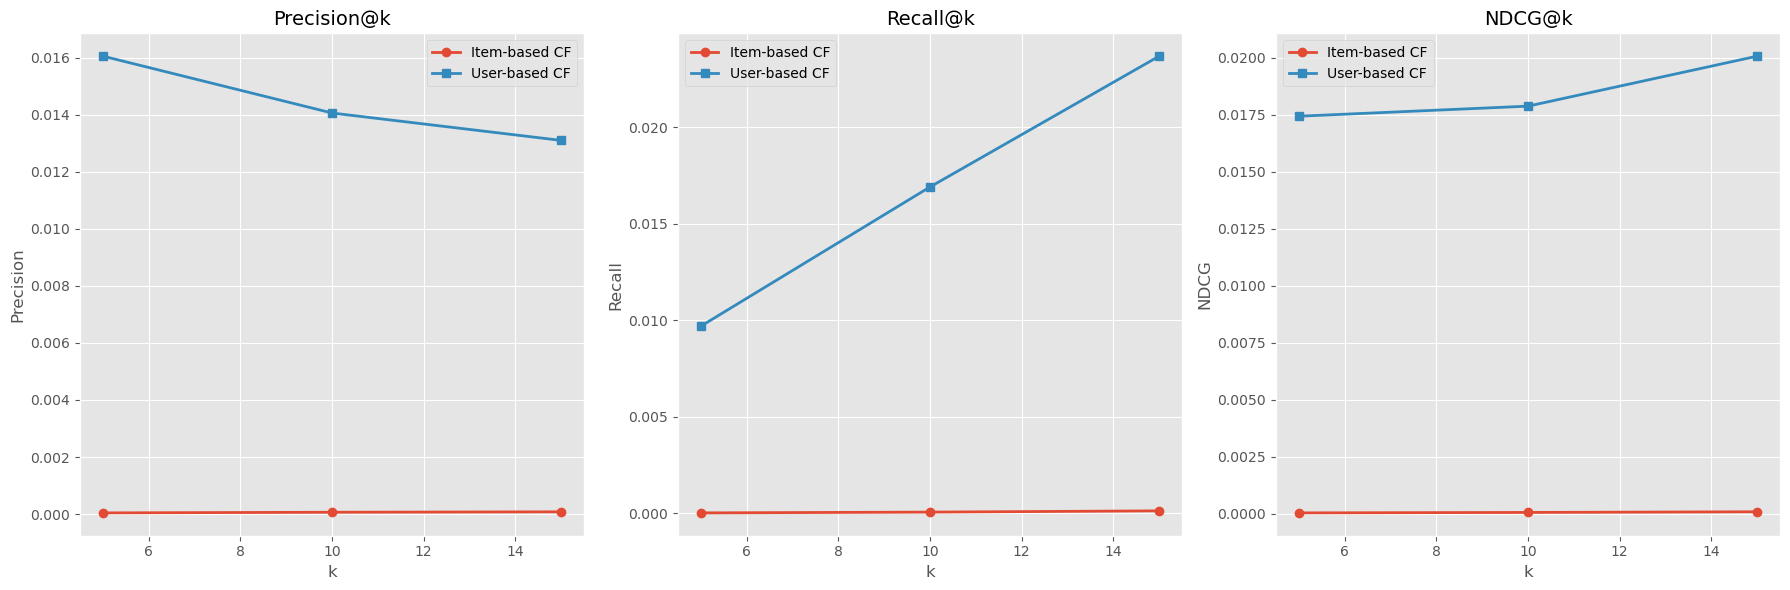


Comparison Summary:
      Metric  Item-based CF  User-based CF
 Precision@5         0.0000         0.0160
    Recall@5         0.0000         0.0097
      NDCG@5         0.0000         0.0174
Precision@10         0.0001         0.0141
   Recall@10         0.0001         0.0169
     NDCG@10         0.0001         0.0179
Precision@15         0.0001         0.0131
   Recall@15         0.0001         0.0237
     NDCG@15         0.0001         0.0201
    Hit Rate         0.0007         0.1303
    Coverage         0.9847         0.9847

Recommendation System Comparison Results:
- Better Precision: User-based CF
- Better Recall: User-based CF
- Better NDCG: User-based CF

Overall Winner: User-based Collaborative Filtering
compare_recommendation_methods took 349.06 seconds to execute

User 3020 has listened to 75 tracks.

Top 5 tracks user has listened to:
1. That's What I Like by Bruno Mars (Played 1.0 times)
2. iSpy (feat. Lil Yachty) by KYLE (Played 0.9591836734693876 times)
3. Werewolves 

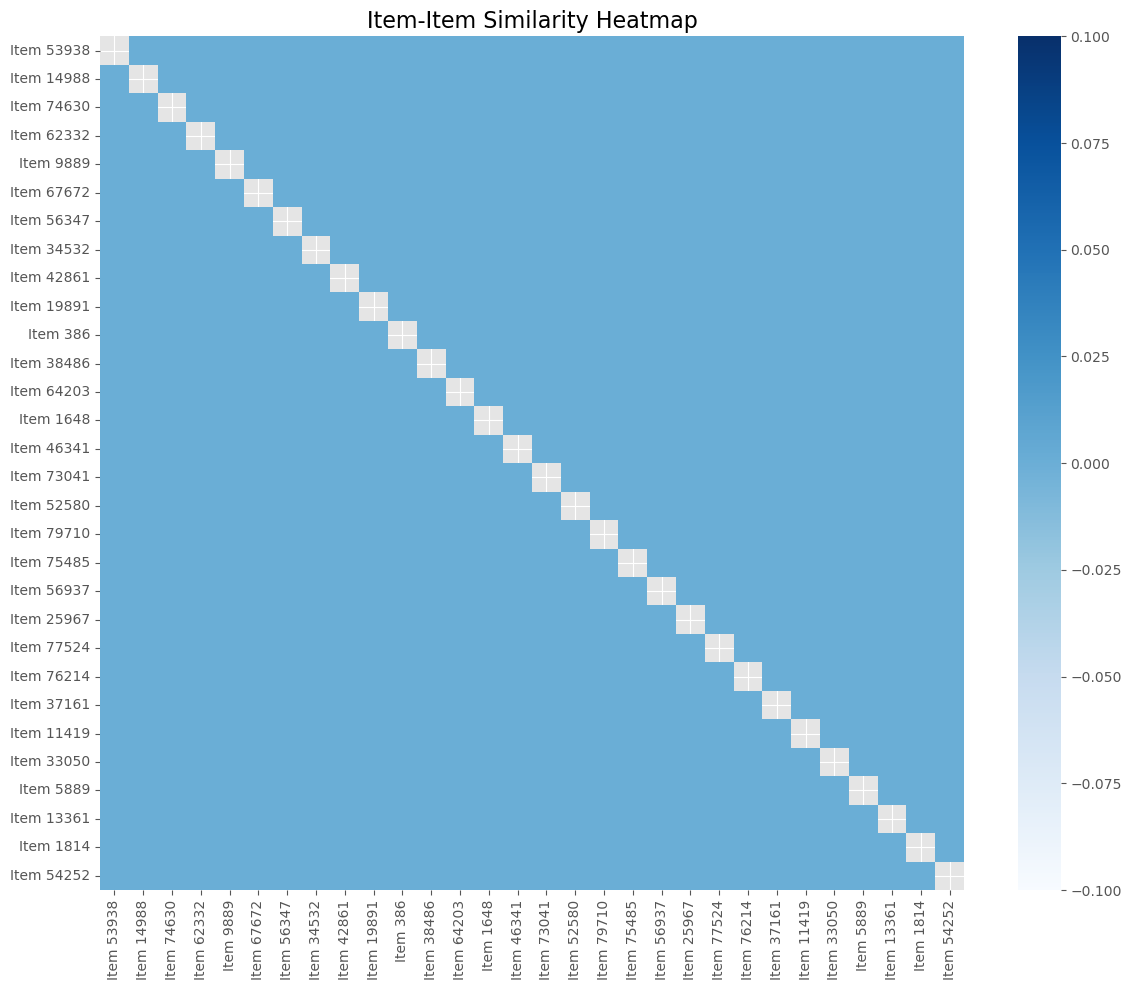

create_similarity_heatmap took 2.17 seconds to execute

Creating User Similarity Heatmap...


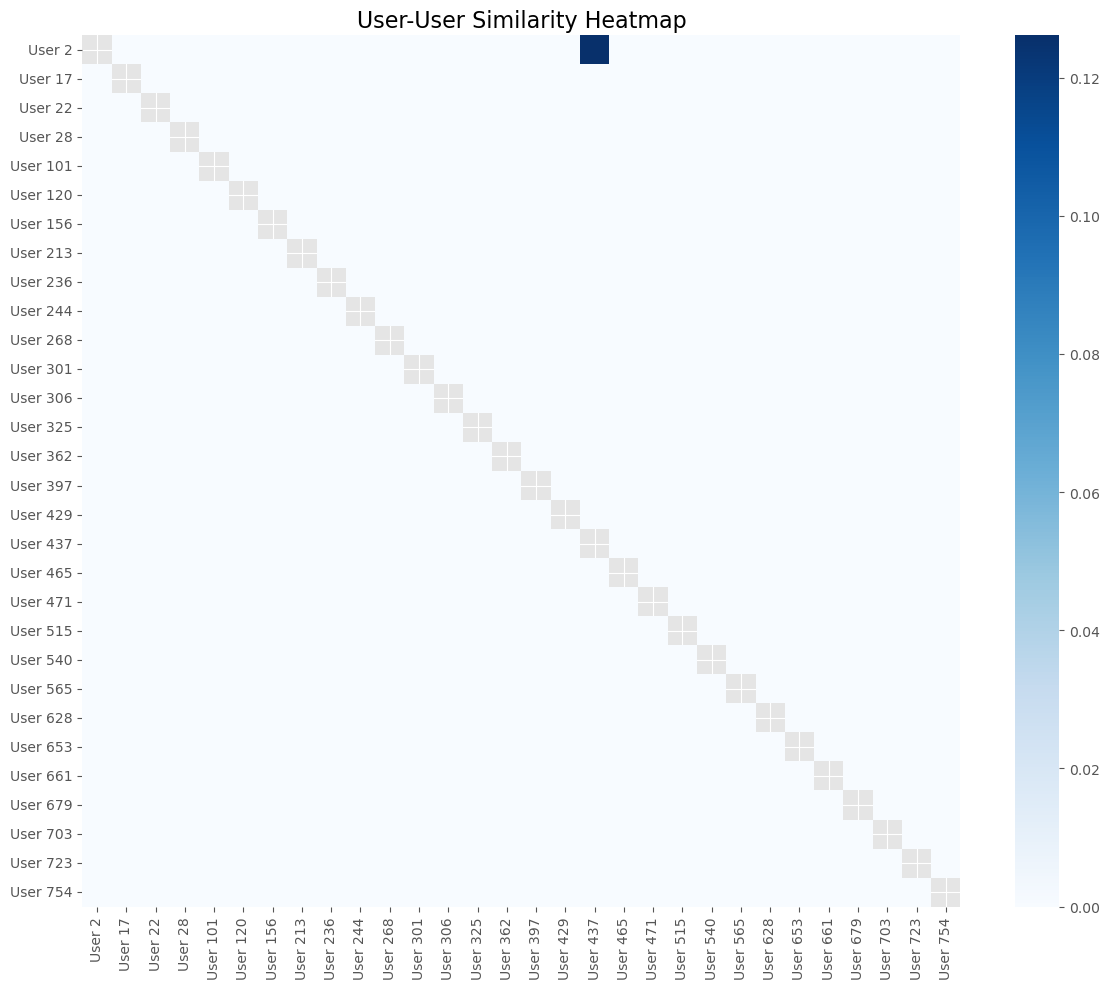

create_similarity_heatmap took 1.64 seconds to execute

Creating Item-based Recommendations Heatmap...


100%|██████████| 50/50 [00:00<00:00, 201.09it/s]


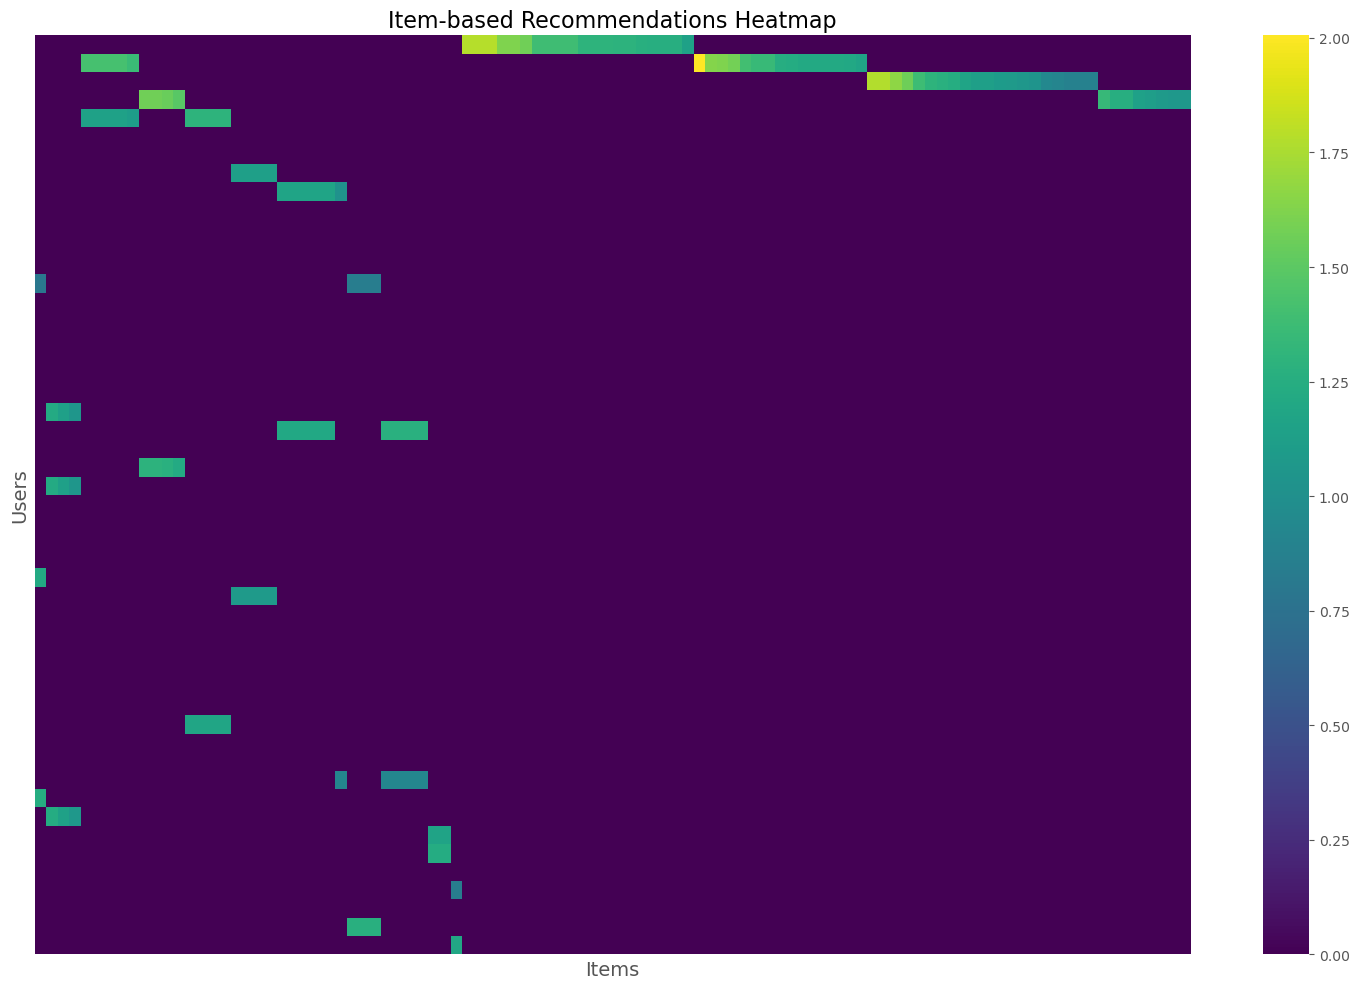

visualize_user_recommendations_heatmap took 0.84 seconds to execute

Creating User-based Recommendations Heatmap...


100%|██████████| 50/50 [00:00<00:00, 188.02it/s]


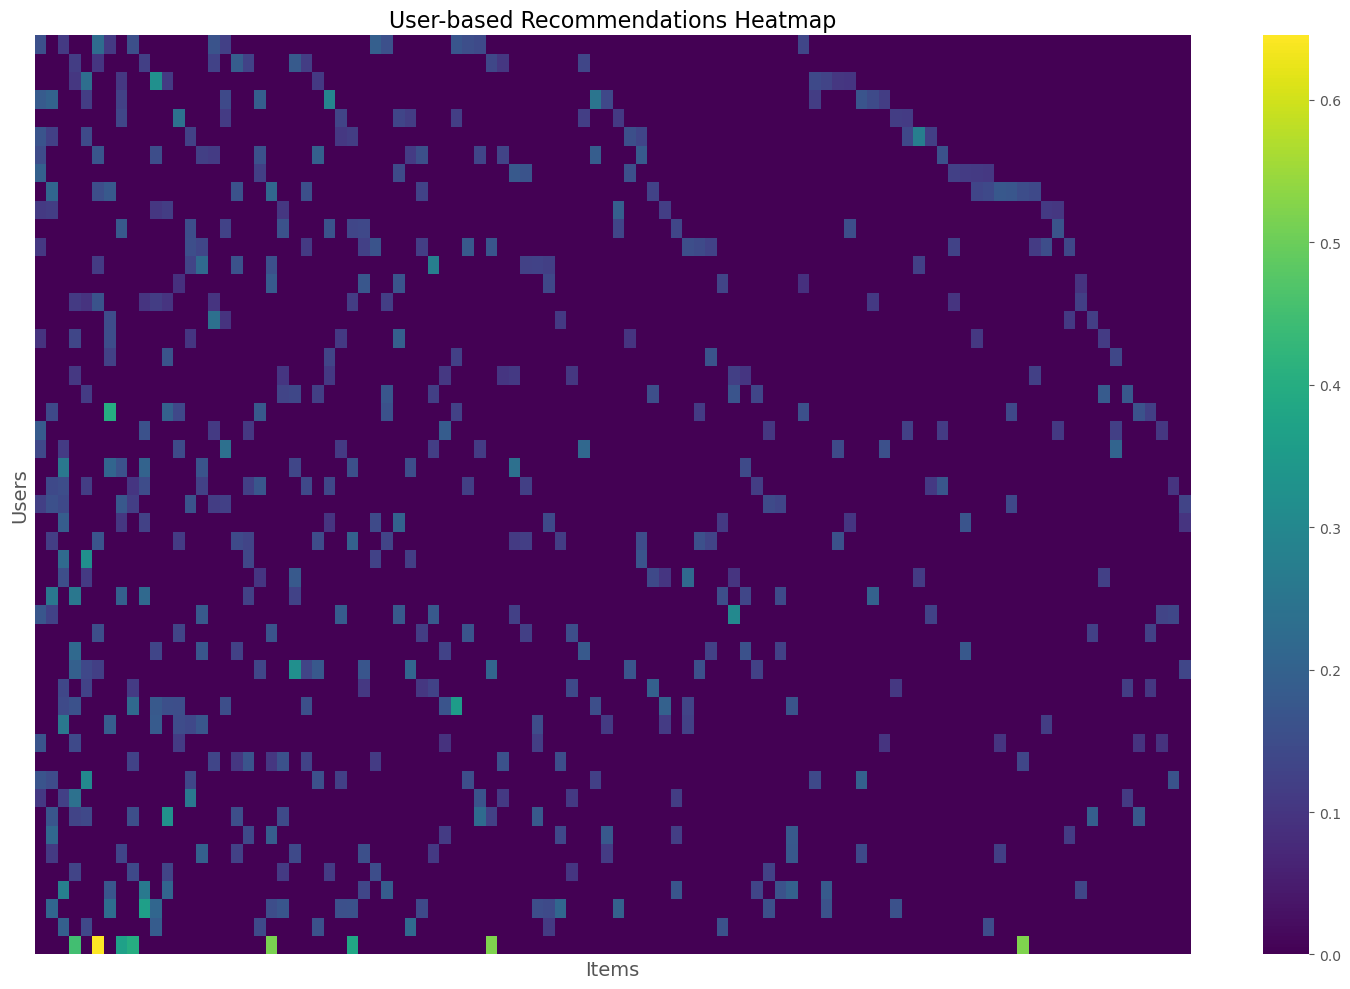

visualize_user_recommendations_heatmap took 0.96 seconds to execute

Analyzing recommendation methods overlap...
visualize_recommendation_patterns took 5.60 seconds to execute


In [12]:

#-------------------------
# OPTIMIZED Evaluation Functions
#-------------------------

# Precompute test user items for faster lookup
@timing_decorator
def precompute_test_data(test_df):
    test_user_items = defaultdict(set)
    user_count = 0
    
    for user_id in tqdm(test_df['user_id'].unique()):
        if user_id in user_mapping:  # Only users we've seen in training
            user_items = set(test_df[test_df['user_id'] == user_id]['track_id'])
            if user_items:
                test_user_items[user_id] = user_items
                user_count += 1
    
    print(f"Precomputed test data for {user_count} users")
    return test_user_items

# Create a test lookup dictionary
test_user_items = precompute_test_data(test_df)
val_user_items = precompute_test_data(val_df)

@timing_decorator
def evaluate_recommendations(test_user_items, get_recommendations_func, top_n=10, max_users=None):
    """
    Evaluate recommendations from any recommendation function.
    
    Parameters:
    - test_user_items: Dictionary mapping user_id to set of test items
    - get_recommendations_func: Function that returns recommendations given a user index
    - top_n: Number of recommendations to generate
    - max_users: Maximum number of users to evaluate (for testing)
    """
    # Metrics
    precision_values = []
    recall_values = []
    ndcg_values = []
    hit_rate = []
    coverage_count = 0
    
    # Limit users for faster evaluation if specified
    if max_users:
        user_ids = list(test_user_items.keys())[:max_users]
    else:
        user_ids = list(test_user_items.keys())
    
    # For each user who has test data
    for user_id in tqdm(user_ids):
        test_items = test_user_items[user_id]
        
        # Skip if no test items
        if len(test_items) == 0:
            continue
        
        # Get user's internal index
        if user_id not in user_mapping:
            continue
            
        user_idx = user_mapping[user_id]
        
        # Get recommendations
        try:
            recommendations = get_recommendations_func(user_idx, top_n)
        except Exception as e:
            print(f"Error getting recommendations for user {user_id}: {e}")
            continue
        
        # Skip if no recommendations
        if not recommendations:
            continue
            
        recommended_items = [item_id for item_id, _ in recommendations]
        
        # Calculate metrics
        hits = len(set(recommended_items) & test_items)
        precision = hits / len(recommended_items) if recommended_items else 0
        recall = hits / len(test_items) if test_items else 0
        
        # NDCG calculation
        dcg = 0
        for i, item in enumerate(recommended_items):
            if item in test_items:
                dcg += 1 / np.log2(i + 2)
        
        idcg = sum(1 / np.log2(i + 2) for i in range(min(top_n, len(test_items))))
        ndcg = dcg / idcg if idcg > 0 else 0
        
        # Hit rate (1 if at least one recommendation is in test items)
        hr = 1 if hits > 0 else 0
        
        # Append metrics
        precision_values.append(precision)
        recall_values.append(recall)
        ndcg_values.append(ndcg)
        hit_rate.append(hr)
        coverage_count += 1
    
    # Calculate averages
    results = {
        f"precision@{top_n}": np.mean(precision_values) if precision_values else 0,
        f"recall@{top_n}": np.mean(recall_values) if recall_values else 0,
        f"ndcg@{top_n}": np.mean(ndcg_values) if ndcg_values else 0,
        "hit_rate": np.mean(hit_rate) if hit_rate else 0,
        "coverage": coverage_count / len(user_mapping) if user_mapping else 0
    }
    
    print(f"Evaluation results (k={top_n}):")
    print(f"Number of users evaluated: {coverage_count}")
    print(f"Precision@{top_n}: {results[f'precision@{top_n}']:.4f}")
    print(f"Recall@{top_n}: {results[f'recall@{top_n}']:.4f}")
    print(f"NDCG@{top_n}: {results[f'ndcg@{top_n}']:.4f}")
    print(f"Hit Rate: {results['hit_rate']:.4f}")
    print(f"User Coverage: {results['coverage']:.4f}")
    
    return results

# Evaluate item-based recommendations
@timing_decorator
def evaluate_item_based_recommendations(test_user_items, top_n=10, max_users=10000, similarity_threshold=0.0):
    print(f"\nEvaluating Item-based CF with top_n={top_n}, max_users={max_users}, threshold={similarity_threshold}")
    
    # Create a custom recommendation function that includes the threshold
    def get_recs_with_threshold(user_idx, top_n):
        return get_item_based_recommendations(user_idx, top_n, similarity_threshold=similarity_threshold)
    
    return evaluate_recommendations(
        test_user_items,
        get_recs_with_threshold,
        top_n=top_n,
        max_users=max_users
    )

# Evaluate user-based recommendations
@timing_decorator
def evaluate_user_based_recommendations(test_user_items, top_n=10, max_users=10000, similarity_threshold=0.0):
    print(f"\nEvaluating User-based CF with top_n={top_n}, max_users={max_users},, threshold={similarity_threshold}")

      # Create a custom recommendation function that includes the threshold
    def get_recs_with_threshold(user_idx, top_n):
        return get_user_based_recommendations(user_idx, top_n, similarity_threshold=similarity_threshold)
        
    return evaluate_recommendations(
        test_user_items,
       get_recs_with_threshold,
        top_n=top_n,
        max_users=max_users
    )

#-------------------------
# OPTIMIZED Visualization Functions
#-------------------------

# Function to compare both recommendation methods
@timing_decorator
def compare_recommendation_methods(max_users=None):
    # Evaluate with different k values
    k_values = [5, 10, 15]
    item_results = []
    user_results = []
    
    for k in k_values:
        print(f"\nEvaluating with k={k}")
        item_result = evaluate_item_based_recommendations(test_user_items, top_n=k, max_users=max_users)
        user_result = evaluate_user_based_recommendations(test_user_items, top_n=k, max_users=max_users)
        item_results.append(item_result)
        user_results.append(user_result)
    
    # Data for plotting
    precision_item = [result[f'precision@{k}'] for result, k in zip(item_results, k_values)]
    recall_item = [result[f'recall@{k}'] for result, k in zip(item_results, k_values)]
    ndcg_item = [result[f'ndcg@{k}'] for result, k in zip(item_results, k_values)]
    
    precision_user = [result[f'precision@{k}'] for result, k in zip(user_results, k_values)]
    recall_user = [result[f'recall@{k}'] for result, k in zip(user_results, k_values)]
    ndcg_user = [result[f'ndcg@{k}'] for result, k in zip(user_results, k_values)]
    
    # Set style
    plt.style.use('ggplot')
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot precision
    axes[0].plot(k_values, precision_item, marker='o', linewidth=2, label='Item-based CF')
    axes[0].plot(k_values, precision_user, marker='s', linewidth=2, label='User-based CF')
    axes[0].set_title('Precision@k', fontsize=14)
    axes[0].set_xlabel('k', fontsize=12)
    axes[0].set_ylabel('Precision', fontsize=12)
    axes[0].legend()
    
    # Plot recall
    axes[1].plot(k_values, recall_item, marker='o', linewidth=2, label='Item-based CF')
    axes[1].plot(k_values, recall_user, marker='s', linewidth=2, label='User-based CF')
    axes[1].set_title('Recall@k', fontsize=14)
    axes[1].set_xlabel('k', fontsize=12)
    axes[1].set_ylabel('Recall', fontsize=12)
    axes[1].legend()
    
    # Plot NDCG
    axes[2].plot(k_values, ndcg_item, marker='o', linewidth=2, label='Item-based CF')
    axes[2].plot(k_values, ndcg_user, marker='s', linewidth=2, label='User-based CF')
    axes[2].set_title('NDCG@k', fontsize=14)
    axes[2].set_xlabel('k', fontsize=12)
    axes[2].set_ylabel('NDCG', fontsize=12)
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig('cf_comparison.png')
    plt.show()
    
    # Create a summary table
    table_data = {
        'Metric': ['Precision@5', 'Recall@5', 'NDCG@5', 'Precision@10', 'Recall@10', 'NDCG@10', 
                'Precision@15', 'Recall@15', 'NDCG@15', 'Hit Rate', 'Coverage'],
        'Item-based CF': [
            item_results[0]['precision@5'], item_results[0]['recall@5'], item_results[0]['ndcg@5'],
            item_results[1]['precision@10'], item_results[1]['recall@10'], item_results[1]['ndcg@10'],
            item_results[2]['precision@15'], item_results[2]['recall@15'], item_results[2]['ndcg@15'],
            item_results[1]['hit_rate'], item_results[1]['coverage']
        ],
        'User-based CF': [
            user_results[0]['precision@5'], user_results[0]['recall@5'], user_results[0]['ndcg@5'],
            user_results[1]['precision@10'], user_results[1]['recall@10'], user_results[1]['ndcg@10'],
            user_results[2]['precision@15'], user_results[2]['recall@15'], user_results[2]['ndcg@15'],
            user_results[1]['hit_rate'], user_results[1]['coverage']
        ]
    }
    
    summary_df = pd.DataFrame(table_data)
    print("\nComparison Summary:")
    print(summary_df.to_string(index=False, float_format='{:.4f}'.format))
    
    # Determine winner
    better_precision = "Item-based" if np.mean(precision_item) > np.mean(precision_user) else "User-based"
    better_recall = "Item-based" if np.mean(recall_item) > np.mean(recall_user) else "User-based"
    better_ndcg = "Item-based" if np.mean(ndcg_item) > np.mean(ndcg_user) else "User-based"
    
    print("\nRecommendation System Comparison Results:")
    print(f"- Better Precision: {better_precision} CF")
    print(f"- Better Recall: {better_recall} CF")
    print(f"- Better NDCG: {better_ndcg} CF")
    
    # Overall winner determination (simple majority voting)
    votes = [better_precision, better_recall, better_ndcg]
    item_votes = votes.count("Item-based")
    user_votes = votes.count("User-based")
    
    if item_votes > user_votes:
        print("\nOverall Winner: Item-based Collaborative Filtering")
    elif user_votes > item_votes:
        print("\nOverall Winner: User-based Collaborative Filtering")
    else:
        print("\nBoth methods perform similarly, consider additional factors like computation time and scalability.")
    
    return item_results, user_results

# Generate example recommendations for a sample user
def show_sample_recommendations():
    # Choose a random user for demonstration
    sample_user_idx = np.random.randint(0, len(user_mapping))
    real_user_id = reverse_user_mapping[sample_user_idx]
    
    # Get user's listening history
    user_tracks = train_df[train_df['user_id'] == real_user_id]
    print(f"\nUser {real_user_id} has listened to {len(user_tracks)} tracks.")
    
    # Show top 5 most played tracks
    top_tracks = user_tracks.sort_values(by='play_count', ascending=False).head(5)
    print("\nTop 5 tracks user has listened to:")
    for i, (_, row) in enumerate(top_tracks.iterrows(), 1):
        print(f"{i}. {row['track_name']} by {row['artist_name']} (Played {row['play_count']} times)")
    
    # Get recommendations from both methods
    item_recs = get_item_based_recommendations(sample_user_idx, top_n=5)
    
    # Only get user-based recs if the user is in our computed similarity dict
    if sample_user_idx in user_similarity_dict:
        user_recs = get_user_based_recommendations(sample_user_idx, top_n=5)
        has_user_recs = True
    else:
        user_recs = []
        has_user_recs = False
    
    # Format and display recommendations
    print("\nItem-based recommendations:")
    for i, (track_id, score) in enumerate(item_recs, 1):
        track_info = train_df[train_df['track_id'] == track_id].iloc[0]
        print(f"{i}. {track_info['track_name']} by {track_info['artist_name']} (Score: {score:.4f})")
    
    if has_user_recs:
        print("\nUser-based recommendations:")
        for i, (track_id, score) in enumerate(user_recs, 1):
            track_info = train_df[train_df['track_id'] == track_id].iloc[0]
            print(f"{i}. {track_info['track_name']} by {track_info['artist_name']} (Score: {score:.4f})")
    else:
        print("\nUser-based recommendations: Not available for this user (not in computed similarity set)")



@timing_decorator
def create_similarity_heatmap(similarity_dict, type_name="Item", top_n=50, sample_size=20):
    """
    Create a heatmap visualization of the similarity matrix.
    
    Parameters:
    - similarity_dict: Dictionary of item/user similarities
    - type_name: "Item" or "User" for labeling
    - top_n: How many top items/users to include
    - sample_size: Number of items/users to sample for the heatmap
    """
    # Get top-n items/users by number of connections
    popularity = Counter({item_id: len(similarities) for item_id, similarities in similarity_dict.items()})
    top_items = [item_id for item_id, _ in popularity.most_common(top_n)]
    
    # Sample from top items
    if len(top_items) > sample_size:
        sampled_items = sorted(np.random.choice(top_items, sample_size, replace=False))
    else:
        sampled_items = sorted(top_items)
    
    # Create similarity matrix for the sample
    sim_matrix = np.zeros((len(sampled_items), len(sampled_items)))
    
    # Fill the similarity matrix
    for i, item_i in enumerate(sampled_items):
        for j, item_j in enumerate(sampled_items):
            if item_j in similarity_dict.get(item_i, {}):
                sim_matrix[i, j] = similarity_dict[item_i][item_j]
    
    # Get labels
    if type_name == "Item":
        labels = [f"Item {reverse_track_mapping[idx][:6]}..." if isinstance(reverse_track_mapping[idx], str) 
                 else f"Item {reverse_track_mapping[idx]}" for idx in sampled_items]
    else:  # User
        labels = [f"User {reverse_user_mapping[idx]}" for idx in sampled_items]
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    mask = np.zeros_like(sim_matrix)
    np.fill_diagonal(mask, 1)  # Mask the diagonal as it's always 1
    
    sns.heatmap(sim_matrix, annot=False, cmap="Blues", mask=mask,
                xticklabels=labels, yticklabels=labels)
    
    plt.title(f"{type_name}-{type_name} Similarity Heatmap", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{type_name.lower()}_similarity_heatmap.png')
    plt.show()
    
    return sim_matrix

@timing_decorator
def visualize_user_recommendations_heatmap(num_users=50, num_items=100, method="item"):
    """
    Create a heatmap showing recommendations across multiple users.
    
    Parameters:
    - num_users: Number of users to sample
    - num_items: Number of unique items to track
    - method: "item" or "user" for the recommendation method
    """
    # Sample users (ideally active users)
    if method == "user":
        # For user-based, use users that are in our similarity dict
        eligible_users = list(user_similarity_dict.keys())
        if len(eligible_users) > num_users:
            sampled_users = sorted(np.random.choice(eligible_users, num_users, replace=False))
        else:
            sampled_users = sorted(eligible_users)
    else:
        # For item-based, any user with interactions works
        user_interaction_counts = np.array(user_item_sparse.sum(axis=1)).flatten()
        active_user_indices = np.argsort(user_interaction_counts)[::-1][:1000]  # Top 1000 active
        if len(active_user_indices) > num_users:
            sampled_users = sorted(np.random.choice(active_user_indices, num_users, replace=False))
        else:
            sampled_users = sorted(active_user_indices[:num_users])
    
    # Get recommendations for each user
    recommendations = []
    for user_idx in tqdm(sampled_users):
        if method == "item":
            user_recs = get_item_based_recommendations(user_idx, top_n=20)
        else:
            user_recs = get_user_based_recommendations(user_idx, top_n=20)
        
        if user_recs:
            recommendations.append((user_idx, user_recs))
    
    # Extract all recommended items
    all_rec_items = []
    for _, user_recs in recommendations:
        all_rec_items.extend([item_id for item_id, _ in user_recs])
    
    # Count frequency of recommendations
    rec_counter = Counter(all_rec_items)
    most_common_items = [item_id for item_id, _ in rec_counter.most_common(num_items)]
    
    # Create a matrix: users x items with recommendation scores
    rec_matrix = np.zeros((len(sampled_users), len(most_common_items)))
    
    # Fill the matrix
    for i, (user_idx, user_recs) in enumerate(recommendations):
        user_rec_dict = {item_id: score for item_id, score in user_recs}
        for j, item_id in enumerate(most_common_items):
            if item_id in user_rec_dict:
                rec_matrix[i, j] = user_rec_dict[item_id]
    
    # Get labels
    user_labels = [f"User {reverse_user_mapping[idx]}" for idx in sampled_users]
    item_labels = [f"Item {item_id}" for item_id in most_common_items]
    
    # Create the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(rec_matrix, cmap="viridis", xticklabels=False, yticklabels=False)
    
    plt.title(f"{method.capitalize()}-based Recommendations Heatmap", fontsize=16)
    plt.xlabel("Items", fontsize=14)
    plt.ylabel("Users", fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{method}_based_recommendations_heatmap.png')
    plt.show()
    
    return rec_matrix, sampled_users, most_common_items

@timing_decorator
def visualize_recommendation_patterns():
    """Create various heatmap visualizations for recommendation patterns."""
    # Create similarity heatmaps
    print("\nCreating Item Similarity Heatmap...")
    item_sim_matrix = create_similarity_heatmap(item_similarity_dict, "Item", top_n=100, sample_size=30)
    
    print("\nCreating User Similarity Heatmap...")
    user_sim_matrix = create_similarity_heatmap(user_similarity_dict, "User", top_n=100, sample_size=30)
    
    # Create recommendation pattern heatmaps
    print("\nCreating Item-based Recommendations Heatmap...")
    item_rec_matrix, item_users, item_items = visualize_user_recommendations_heatmap(
        num_users=50, num_items=100, method="item")
    
    print("\nCreating User-based Recommendations Heatmap...")
    user_rec_matrix, user_users, user_items = visualize_user_recommendations_heatmap(
        num_users=50, num_items=100, method="user")
    
    # Create a visualization comparing recommendation overlap
    print("\nAnalyzing recommendation methods overlap...")
    if len(set(item_users) & set(user_users)) > 0:
        # Find common users
        common_users = sorted(list(set(item_users) & set(user_users)))
        common_items = sorted(list(set(item_items) & set(user_items)))
        
        # If we have common elements, create an overlap visualization
        if len(common_users) >= 10 and len(common_items) >= 10:
            # Sample for visualization
            sample_users = sorted(np.random.choice(common_users, min(20, len(common_users)), replace=False))
            sample_items = sorted(np.random.choice(common_items, min(50, len(common_items)), replace=False))
            
            # Create matrices for comparison
            item_matrix = np.zeros((len(sample_users), len(sample_items)))
            user_matrix = np.zeros((len(sample_users), len(sample_items)))
            
            # Get recommendations for sample users
            for i, user_idx in enumerate(sample_users):
                item_recs = get_item_based_recommendations(user_idx, top_n=30)
                user_recs = get_user_based_recommendations(user_idx, top_n=30)
                
                item_rec_dict = {item_id: score for item_id, score in item_recs}
                user_rec_dict = {item_id: score for item_id, score in user_recs}
                
                for j, item_id in enumerate(sample_items):
                    if item_id in item_rec_dict:
                        item_matrix[i, j] = 1
                    if item_id in user_rec_dict:
                        user_matrix[i, j] = 1
            
            # Calculate overlap
            overlap_matrix = (item_matrix + user_matrix) - 1
            overlap_matrix[overlap_matrix < 0] = 0
            
            # Create comparison visualization
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
            
            sns.heatmap(item_matrix, cmap="Blues", ax=ax1, cbar=False, xticklabels=False, yticklabels=False)
            ax1.set_title("Item-based Recommendations", fontsize=14)
            ax1.set_xlabel("Items")
            ax1.set_ylabel("Users")
            
            sns.heatmap(user_matrix, cmap="Greens", ax=ax2, cbar=False, xticklabels=False, yticklabels=False)
            ax2.set_title("User-based Recommendations", fontsize=14)
            ax2.set_xlabel("Items")
            ax2.set_ylabel("Users")
            
            sns.heatmap(overlap_matrix, cmap="Reds", ax=ax3, cbar=False, xticklabels=False, yticklabels=False)
            ax3.set_title("Recommendation Overlap", fontsize=14)
            ax3.set_xlabel("Items")
            ax3.set_ylabel("Users")
            
            plt.tight_layout()
            plt.savefig('recommendation_method_comparison.png')
            plt.show()
            
            # Calculate and display overlap statistics
            total_recs_item = item_matrix.sum()
            total_recs_user = user_matrix.sum()
            total_overlap = overlap_matrix.sum()
            
            overlap_percent = (total_overlap / min(total_recs_item, total_recs_user)) * 100
            
            print(f"\nRecommendation Overlap Analysis:")
            print(f"Item-based recommendations: {int(total_recs_item)}")
            print(f"User-based recommendations: {int(total_recs_user)}")
            print(f"Overlapping recommendations: {int(total_overlap)}")
            print(f"Overlap percentage: {overlap_percent:.2f}%")
            
            return overlap_percent
    
    return None
  

#-------------------------
# Run the evaluation
#-------------------------

if __name__ == "__main__":

    best_ndcg_item = -1
    best_threshold_item = 0.0

    best_ndcg_user = -1
    best_threshold_user = 0.0

    print("---------------------------------------------------")

    for similarity_threshold in [0.0, 0.1, 0.2, 0.3]:
      print(f"\nEvaluating with threshold={similarity_threshold}")

    # Evaluate item-based CF
      val_results_item = evaluate_item_based_recommendations(
        val_user_items, top_n=10, max_users=None, similarity_threshold=similarity_threshold)

      print("---------------------------------------------------")
    
    # Evaluate user-based CF
      val_results_user = evaluate_user_based_recommendations(
        val_user_items, top_n=10, max_users=None, similarity_threshold=similarity_threshold)

    # Track best threshold for item-based
      if val_results_item['ndcg@10'] > best_ndcg_item:
        best_ndcg_item = val_results_item['ndcg@10']
        best_threshold_item = similarity_threshold

    # Track best threshold for user-based
      if val_results_user['ndcg@10'] > best_ndcg_user:
        best_ndcg_user = val_results_user['ndcg@10']
        best_threshold_user = similarity_threshold

    # Print results
    print(f"\nBest similarity threshold for Item-based CF: {best_threshold_item} (NDCG@10: {best_ndcg_item:.4f})")
    print(f"Best similarity threshold for User-based CF: {best_threshold_user} (NDCG@10: {best_ndcg_user:.4f})")
    print("---------------------------------------------------")

    #The best one is threshold 0.0, so we use 0.0 for final evaluation
    
    # Compare both methods and visualize results
    item_results, user_results = compare_recommendation_methods()
    
    # Show sample recommendations
    show_sample_recommendations()

    visualize_recommendation_patterns()
    
